### Section 3: Data Modelling | Recommender system | Neural Nets: sensitivity to data cleaning

**Objective: **Imagine you have been tasked to build a recommendation system. Some training data is available at https://goo.gl/mHPsHM. The user-item ratings are in the form of {1, 2, 3, 4} s.t. 1=Hate, 2=Dislike, 3=Like, 4=Love. You have the option of treating this problem as either a regression- or multi-class classification-problem. The end goal is to develop a system which takes the user attributes as input and outputs the user-item rating.

#### Comments and results

By analysing the data we observe small long tails in the distribution of number of items rated per user (measure of how active is that user), and in the distribution of number of ratings received by each item (measure of how popular is an item). 

The idea is to remove ratings that belong to:

* users who have interacted with many items -they add less useful information as they are not selective enough
* items that have many ratings -items that many users like will tend to be overly recommended


Items - Filtered above 90 ratings received removed 14 out of 805 items

Users - Filtered below 5 items rated removed 333 out of 1905 users

None of both data cleaning options seemed to improve the RMSE accuracy, with a NN of 

### Neural Net recommender system

In [6]:
import torch
import torchvision
import numpy as np
import pandas as pd
import random, math
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

ratings = pd.read_csv('../../data/recommender/user_item_ratings.csv')

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

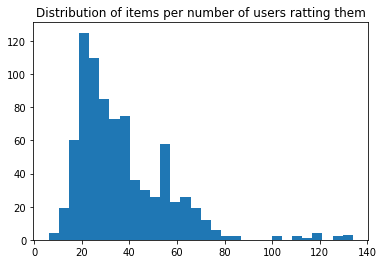

In [7]:
users_per_item = pd.pivot_table(ratings, index=['ItemID'], aggfunc=lambda x: len(x != 0), fill_value=0)
users_per_item.sort_values(by='UserID', ascending=False, inplace=True)
users_per_item.reset_index(inplace=True)

plt.title('Distribution of items per number of users ratting them')
plt.hist(users_per_item.UserID, bins=30)
plt.tight_layout

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

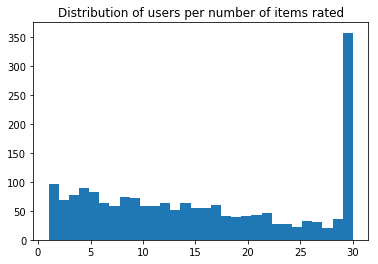

In [8]:
items_per_user = pd.pivot_table(ratings, index=['UserID'], aggfunc=lambda x: len(x != 0), fill_value=0)
items_per_user.sort_values(by='ItemID', ascending=False, inplace=True)
    
plt.title('Distribution of users per number of items rated')
plt.hist(items_per_user.ItemID, bins=30)
plt.tight_layout

In [53]:
def filter_high_rated_items(ratings, thres=60):

    users_per_item = pd.pivot_table(ratings, index=['ItemID'], aggfunc=lambda x: len(x != 0), fill_value=0)
    users_per_item.sort_values(by='UserID', ascending=False, inplace=True)
    users_per_item.reset_index(inplace=True)

#     plt.title('Distribution of items per number of users ratting them')
#     plt.hist(users_per_item.UserID, bins=30)
#     plt.tight_layout

    # user id rated for more than 90-100 users
    uaX = list(users_per_item[users_per_item.UserID > thres].index)
    print('Cutting above %d ratings received removes %d out of %d items' %(thres, len(uaX), len(users_per_item.ItemID)))
    
    ratings_pt = pd.pivot_table(ratings, index=['ItemID'], columns=['UserID'], fill_value=0, dropna=True)
    ratings_pt.reset_index(inplace=True)
    ratings_pt.shape

    ibX_ids = set(ratings_pt.ItemID).difference(set(uaX))

    ubX_ratings = ratings[ratings.ItemID.isin(ibX_ids)]
    ubX_ratings_pt = pd.pivot_table(ubX_ratings, index=['UserID'], columns=['ItemID'], fill_value=0, dropna=True)
    
    return ubX_ratings, ubX_ratings_pt

def filter_low_activity_users(ratings, thres=10):
    
    items_per_user = pd.pivot_table(ratings, index=['UserID'], aggfunc=lambda x: len(x != 0), fill_value=0)
    items_per_user.sort_values(by='ItemID', ascending=False, inplace=True)
    items_per_user.reset_index(inplace=True)
    
#     plt.title('Distribution of users per number of items rated')
#     plt.hist(items_per_user.ItemID, bins=30)
#     plt.tight_layout

    # user id below 5 items rated
    ubX = list(items_per_user[items_per_user.ItemID < thres].index)

    ratings_pt = pd.pivot_table(ratings, index=['UserID'], columns=['ItemID'], fill_value=0, dropna=True)
    ratings_pt.reset_index(inplace=True)
    ratings_pt

    uaX_ids = set(ratings_pt.UserID).difference(set(ubX))

    print('Cutting below %d items rated removes %d out of %d users' %(thres, len(ubX), len(items_per_user.ItemID)))

    uaX_ratings = ratings[ratings.UserID.isin(uaX_ids)]
    uaX_ratings_pt = pd.pivot_table(uaX_ratings, index=['UserID'], columns=['ItemID'], fill_value=0, dropna=True)
    
    return uaX_ratings, uaX_ratings_pt

def load_data(load_upd=True, conf_file=None, filter_items=False, filter_users=False):

    # Loading ratings data

    ratings = pd.read_csv('../../data/recommender/user_item_ratings.csv')
    ratings_pt = pd.pivot_table(ratings, index=['UserID'], columns=['ItemID'], fill_value=0, dropna=True)

    if filter_items: ratings, ratings_pt = filter_high_rated_items(ratings)
    if filter_users: ratings, ratings_pt = filter_low_activity_users(ratings)
        
    sparse_ratings = ratings_pt.values

    users_ids = np.unique(ratings['UserID'])
    items_ids = np.unique(ratings['ItemID'])
    n_users, n_items, n_atts = len(users_ids), len(items_ids), None

    if load_upd:
        
        # Loading user profiles data

        user_profiles = pd.read_csv('../../data/recommender/user_attributes.csv')
        user_profiles = user_profiles[user_profiles.UserID.isin(ratings.UserID)]
        user_profiles.sort_values(by='UserID', ascending=True, inplace=True)
        user_profiles.drop('UserID', axis=1, inplace=True)
        user_profiles.reset_index(inplace=True, drop=True)
        
        user_profiles = user_profiles.values
        
        n_users_profiles, n_atts = user_profiles.shape[0], user_profiles.shape[1]
        assert n_users == n_users_profiles

    print('Interaction matrix of %d users and %d items | Num. of interactions: %d | Num. of attributes per user: %s\n' 
          %(n_users, n_items, len(sparse_ratings.nonzero()[0]), str(n_atts)), end='')
    
    if not conf_file: conf_file = {}
    conf_file['n_users'] = n_users
    conf_file['n_items'] = n_items
    conf_file['n_factors'] = n_atts
    
    return sparse_ratings, user_profiles if load_upd else None, conf_file

sparse_ratings, user_profiles, conf_file = load_data(filter_items=True, filter_users=True)

Cutting above 60 ratings received removes 87 out of 805 items
Cutting below 10 items rated removes 739 out of 1888 users
Interaction matrix of 1161 users and 718 items | Num. of interactions: 16132 | Num. of attributes per user: 50


In [54]:
from torch.utils.data import DataLoader, Dataset

class UserItemInteractionsDataset(Dataset):
    def __init__(self, inters_sparse_matrix, mode):
        super().__init__()
        """
        'ix', 'ixs' and 'v' stand for index and value
        """
        self.inters = inters_sparse_matrix
        self.mode = mode
        
        # retrieve ratings indexes
        users_ixs, items_ixs = inters_sparse_matrix.nonzero()
        n_users, n_items, n_inters = len(np.unique(users_ixs)), len(np.unique(items_ixs)), len(users_ixs)

        self.data = {'users_ixs': users_ixs, 'items_ixs' : items_ixs}
    
        # shuffle and split data
        ss_ix = np.random.permutation(n_inters)
        ss_ixs = {'train': ss_ix[:len(ss_ix) * 3 // 5], 
                  'eval': ss_ix[len(ss_ix) * 3 // 5: len(ss_ix) * 4 // 5],
                  'test': ss_ix[len(ss_ix) * 4 // 5:]}
        
        self.dataset = {i: j[ss_ixs[mode]] for i, j in self.data.items()}
        self.dataset_size =  len(ss_ixs[mode])

        print('Setting "%s" dataset with %d users, %d items and %d interactions' %(mode, 
                                                                                len(np.unique(self.dataset['users_ixs'])),
                                                                                len(np.unique(self.dataset['items_ixs'])),
                                                                                len(ss_ixs[mode])))
        
    def __getitem__(self, index):
        
        user_ix, item_ix = self.dataset['users_ixs'][index], self.dataset['items_ixs'][index]
                
        user_ix_tensor = Variable(torch.LongTensor([user_ix]))
        item_ix_tensor = Variable(torch.LongTensor([item_ix]))
        inter_v_tensor = Variable(torch.FloatTensor([self.inters[user_ix, item_ix]]))        
        
        return user_ix_tensor, item_ix_tensor, inter_v_tensor

    def __len__(self):
        return self.dataset_size
    

# example:
# print(dataset_ev.__getitem__(0))
# if we want to retrieve the original id number: users_ids[user_ix]

def train_and_eval_model(dataloaders, model, optimizer, loss_fn, scheduler=None, epochs=10, verbose=True):

    modes = ['train', 'eval']
    losses = {i: [] for i in modes}
    
    print('\nTraining...')
    for e in range(epochs):
        for mode in modes:
            if mode == 'train': model.train()
            elif mode == 'eval': model.eval()
            else: print('WRONG!')

            per_batch_losses = []
            for _, batch in enumerate(dataloaders[mode]): 

                # index of the sparse matrix
                user_ix, item_ix, inter_v = batch

                # predict
                inter_v_pred = model(user_ix, item_ix)
#                 loss = loss_fn(inter_v_pred, inter_v)
                loss = loss_fn(inter_v_pred.view(inter_v.shape), inter_v)

                per_batch_losses.append(loss.item())

                # backpropagate & update weights
                if mode == 'train': 
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

            epoch_loss = np.asarray(per_batch_losses).mean()
            losses[mode].append(epoch_loss)
            
            if verbose:
                if mode == 'train': print('epoch: %d | training loss: %.2f | ' %(e, epoch_loss), end='')
                else: print('validation loss: %.2f' %epoch_loss)
                
        if scheduler: scheduler.step()
                
    return losses

def eval_model(dataloaders, model, optimizer, loss_fn=torch.nn.MSELoss(), epochs=1):
    
    losses = []
    
    for e in range(epochs):
        for mode in ['test']:
            
            model.eval()
            
            per_batch_losses = []
            for _, batch in enumerate(dataloaders[mode]): 

                # index of the sparse matrix
                user_ix, item_ix, inter_v = batch

                # predict
                inter_v_pred = model(user_ix, item_ix)
                loss = loss_fn(inter_v_pred.view(inter_v.shape), inter_v)

                per_batch_losses.append(loss.item())

        epoch_loss = np.asarray(per_batch_losses).mean()
        losses.append(epoch_loss)
        
    print('\n *** test loss: MSE %.2f | RMSE %.2f ***\n' %(np.asarray(losses).mean(), math.sqrt(np.asarray(losses).mean())))
                
def predict_item(model, datasets, loss_fn=torch.nn.MSELoss()):

    eg = random.randint(0, len(datasets['test']))

    user_ix, item_ix, inter_v = (i.unsqueeze(0) for i in datasets['test'].__getitem__(eg))
    inter_v_pred = model(user_ix, item_ix)
    loss = loss_fn(inter_v_pred.view(inter_v.shape), inter_v)

    print('Example [test dataset] - Predicted rating: %.2f | Rating: %.2f | Loss: MSE %.4f RMSE: %.4f' 
          %(inter_v_pred, inter_v, loss, math.sqrt(loss)))

In [55]:
class UserItemNNet(torch.nn.Module):
    
    def __init__(self, config_file, user_profiles=None, p_drop=0.):
        super().__init__()
        
        n_users, n_items, n_factors = (config_file[i] for i in ['n_users', 'n_items', 'n_factors'])

        self.user_factors = torch.nn.Embedding(n_users, n_factors) #, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors) #, sparse=True)
        self.user_biases = torch.nn.Embedding(n_users, 1) #, sparse=True)
        self.item_biases = torch.nn.Embedding(n_items, 1) #, sparse=True)
        
        exp_depth = config_file['expansion_depth']
        self.fc_layers = [n_factors * 2]
        [self.fc_layers.append(self.fc_layers[-1] * 2) for i in range(exp_depth)]
        [self.fc_layers.append(self.fc_layers[-1] // 2) for i in range(exp_depth)]
        
        self.fc_module = torch.nn.ModuleList()
        for _, (in_size, out_size) in enumerate(zip(self.fc_layers[:-1], self.fc_layers[1:])):
            self.fc_module.append(torch.nn.Linear(in_size, out_size))
        
        # either
        self.fc_module.append(torch.nn.Linear(self.fc_layers[-1], 1))
        # or
#         self.fc_out = torch.nn.Linear(torch.nn.Linear(self.fc_layers[-1], 1))
        
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(p=p_drop)
            
        self.user_profiles = user_profiles
        if user_profiles is not None: 
            assert n_factors == user_profiles.shape[1]
            n_factors = user_profiles.shape[1]
      
    def forward(self, user, item, max_v=4., min_v=1.):
        "MF-like bit:"
        'users & items embedding matrices'
        if self.user_profiles is not None: 
            user_profiles = torch.FloatTensor(self.user_profiles)
            ufs = user_profiles[user] * torch.nn.ReLU()((self.user_factors(user)))
        else: 
            ufs = self.dropout(torch.nn.ReLU()((self.user_factors(user))))
#         ufs += self.user_biases(user).view(ufs.shape)
        ifs = self.dropout(torch.nn.ReLU()((self.item_factors(item))))
#         ifs += self.item_biases(item).view(ifs.shape)
#         pred = (ufs * ifs).sum(-1)
#         pred += (self.user_biases(user) + self.item_biases(item)).view(pred.shape)
        
        "NN-like bit:"
        if self.user_profiles is not None: 
            ups = torch.FloatTensor(self.user_profiles)[user]
        out = torch.cat([ufs, ifs], dim=-1)  # concat. the output of the MF bit
        for linear_layer in self.fc_module:
#             print(out.shape)
            out = torch.nn.BatchNorm1d(1)(out)
            out = torch.nn.ReLU()(out)
            out = linear_layer(out)
            # out = self.dropout(out)
#         print(out.shape)
        out = self.sigmoid(out) * (max_v - min_v) + min_v
        return out

Interaction matrix of 1912 users and 805 items | Num. of interactions: 29464 | Num. of attributes per user: 50
Setting "train" dataset with 1854 users, 805 items and 17678 interactions
Setting "eval" dataset with 1589 users, 800 items and 5893 interactions
Setting "test" dataset with 1604 users, 801 items and 5893 interactions
UserItemNNet(
  (user_factors): Embedding(1912, 50)
  (item_factors): Embedding(805, 50)
  (user_biases): Embedding(1912, 1)
  (item_biases): Embedding(805, 1)
  (fc_module): ModuleList(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.0)
)

Training...

 *** test loss: MSE 0.46 | RMSE 0.68 ***

Example [test dataset] - Predicted rating: 2.47 | Rating: 3.00 

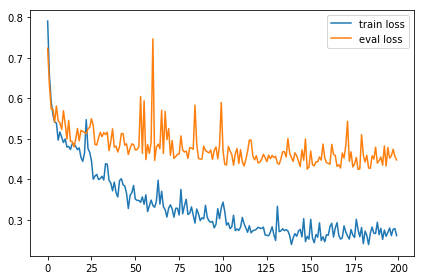

In [57]:
conf_file = {
              'expansion_depth': 2, # depth of the NN // 2 
              'l2_regularization': 1e-7, 
              'model_dir':'checkpoints/{}_Epoch_{}_bs_{}_lr_{:.4f}_RMSE_{:.4f}.model'
}

def main(conf_file):
    epochs = 200
    modes = ['train', 'eval', 'test']
    
    sparse_ratings, user_profiles, conf_file = load_data(conf_file=conf_file, filter_items=0, filter_users=0)
    
    datasets = {i: UserItemInteractionsDataset(sparse_ratings, i) for i in modes}
    dataloaders = {i: DataLoader(datasets[i], batch_size=512, shuffle=True, num_workers=0) for i in modes}

    loss_fn = torch.nn.MSELoss()
    model = UserItemNNet(conf_file, user_profiles=user_profiles, p_drop=0.); print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100)
#     torch.optim.SGD(model.parameters(), lr=1e-1)
    
    losses = train_and_eval_model(dataloaders, model, optimizer, loss_fn, scheduler=scheduler, epochs=epochs, verbose=False)
    eval_model(dataloaders, model, optimizer)
    
    plt.plot(losses['train'])
    plt.plot(losses['eval'])
    plt.tight_layout() 
    plt.legend(['train loss', 'eval loss'])
    
    predict_item(model, datasets)
    
main(conf_file)